In [1]:
import sys
sys.path.insert(0, r'../../quetzal/')
import syspy

import osmnx as ox
import geopandas as gpd
ipath = r'inputs/'

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

In [3]:
## download osm data
## match links/nodes on the road network
## match gps tracks on the road network

In [4]:
zones = gpd.read_file(ipath + r'zones_with_problems.geojson')

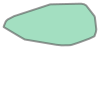

In [5]:
from shapely.geometry import MultiPolygon
hull = MultiPolygon(zones.geometry.values).convex_hull
hull

# OSMNX API

Download OSM road data on a given perimeter

In [6]:
drive = ox.graph_from_polygon(hull, network_type='drive')

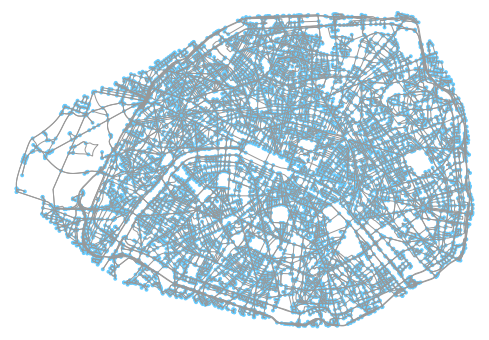

In [7]:
plot = ox.plot_graph(drive)

In [8]:
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [9]:
road_nodes.head()

,y,x,osmid,highway,ref,geometry
5509971973,48.865456,2.391081,5509971973,NaN,NaN,POINT (2.39108 48.86546)
166297606,48.816416,2.360144,166297606,NaN,NaN,POINT (2.36014 48.81642)
116129800,48.844563,2.287032,116129800,NaN,NaN,POINT (2.28703 48.84456)
116129802,48.843989,2.288553,116129802,NaN,NaN,POINT (2.28855 48.84399)
174981131,48.868526,2.386192,174981131,NaN,NaN,POINT (2.38619 48.86853)


In [12]:
road_links.head()

,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,lanes,junction,bridge,ref,service,tunnel,access,width
0,5509971973,148942879,0,573814820,Rue Raoul Dufy,residential,30,False,35.570,"LINESTRING (2.39108 48.86546, 2.39113 48.86520...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,166297606,25240349,0,"[8059024, 362885203, 231974351]",NaN,trunk_link,30,True,311.210,"LINESTRING (2.36014 48.81642, 2.35994 48.81639...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,166297606,249076496,0,"[59942017, 85730575]",Avenue de la Porte d'Italie,primary,30,True,44.665,"LINESTRING (2.36014 48.81642, 2.36007 48.81629...",4,circular,yes,NaN,NaN,NaN,NaN,NaN
3,116129800,141552825,0,369289638,Rue de l'Église,residential,30,True,81.273,"LINESTRING (2.28703 48.84456, 2.28696 48.84459...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,116129800,94258423,0,666195962,Rue de Lourmel,residential,30,True,100.552,"LINESTRING (2.28703 48.84456, 2.28700 48.84452...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean OSM data

In [13]:
from syspy.spatial.graph.graphbuilder import OsmnxCleaner

In [14]:
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='u', 
    b='v'
)

In [15]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False
)
oc.clean_geometries()
oc.fix_nodeset_consistency()

In [16]:
# drop duplicated links
oc.links['osmid_tuple'] = oc.links['osmid'].apply(lambda x: tuple(x) if isinstance(x, list) else tuple([x]))
oc.links = oc.links.drop_duplicates(subset=['a', 'b', 'osmid_tuple'])

In [17]:
oc.links[['a', 'b', 'length', 'geometry']].to_file(ipath + r'osm/road_links.geojson', driver='GeoJSON')
oc.nodes[['geometry']].to_file(
    ipath + r'osm/road_nodes.geojson', driver='GeoJSON'
)

# Match

Project a given route / list of links on the road network

In [18]:
# read route/links
routes = gpd.read_file(ipath + r'osm/route.geojson')

from quetzal.io import importer
links, nodes = importer.links_and_nodes(routes.geometry.values[0])
links = links.loc[links['direction_id']==0]
links, nodes = gpd.GeoDataFrame(links), gpd.GeoDataFrame(nodes)

<AxesSubplot:>

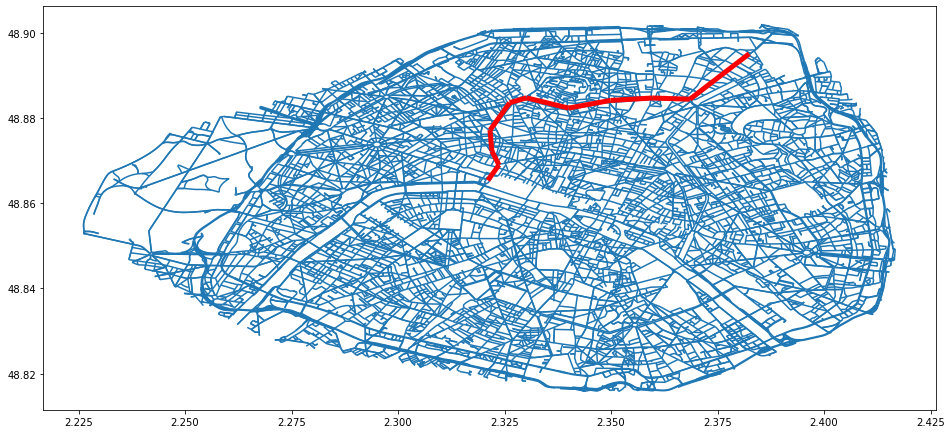

In [21]:
ax = road_links.plot()
links.plot(
    ax=ax, color='r', linewidth=5
)

In [22]:
from quetzal.engine.add_network import NetworkCaster
# init
links['trip_id'] = '1' # required keyword
nc = NetworkCaster(nodes, links, oc.nodes, oc.links)


In [23]:
# build the projected links
nc.build(
    penalty_factor=2,
    geometry=True,
)

1: 100%|██████████| 1/1 [00:00<00:00, 100.46it/s]


In [24]:
nc.links.head()

,a,b,link_sequence,direction_id,trip_id,road_a,road_b,road_node_list,road_link_list,road_length,geometry
0,0,1,0,0,1,202118936,2401441954,"[202118936, 367950.0, 94188138.0, 884214101.0,...","[3914, 4991, 8503, 1740, 16012, 91, 17546, 164...",1554.857,"LINESTRING (2.38233 48.89479, 2.38227 48.89474..."
1,1,2,1,0,1,2401441954,2864793308,"[2401441954, 432814410.0, 122628005.0, 9418576...","[4262, 9490, 6851, 7058, 8467, 11665]",676.287,"LINESTRING (2.36859 48.88417, 2.36845 48.88420..."
2,2,3,2,0,1,2864793308,408479981,"[2864793308, 8122172369.0, 94249865.0, 6504194...","[11666, 721, 6233, 4904, 18037, 11853, 11927, ...",758.892,"LINESTRING (2.35938 48.88453, 2.35921 48.88453..."
3,3,4,3,0,1,408479981,583011683,"[408479981, 361112.0, 94233621.0, 367932.0, 19...","[16782, 536, 16138, 4980, 18513, 16295, 16811,...",776.337,"LINESTRING (2.34948 48.88413, 2.34948 48.88396..."
4,4,5,4,0,1,583011683,272677541,"[583011683, 94177951.0, 256024828.0, 94226653....","[2295, 1898, 5780, 11977, 18158, 4976, 16450, ...",791.476,"LINESTRING (2.33964 48.88217, 2.33951 48.88219..."


<AxesSubplot:>

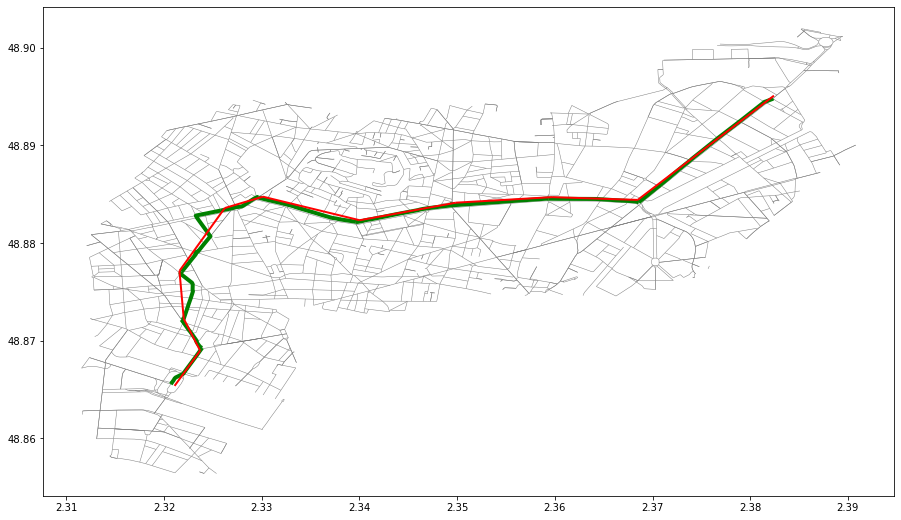

In [25]:
buffer = routes.buffer(0.01).values[0]
ax = oc.links.loc[oc.links.within(buffer)].plot(linewidth=0.5, color='grey')
ax = nc.links.plot(color='g', ax=ax, linewidth=4)
links.plot(ax=ax, color='r', linewidth=2)